# 📝 Task 1 – EDA & Complaint Narrative Exploration  
📘 Version: 2025-07-06  

Structured exploratory data analysis (EDA) and text quality assessment for **CrediTrust Financial’s Intelligent Complaint Analysis Initiative**. This notebook analyzes unstructured consumer complaint narratives to uncover patterns in product-related grievances, complaint volume distribution, text length variability, and data readiness for embedding and retrieval. Outputs from this task will inform chunking, embedding (Task 2), and Retrieval-Augmented Generation (Task 3).

---

**Challenge:** B5W6 – Intelligent Complaint Analysis  
**Company:** CrediTrust Financial  
**Author:** Nabil Mohamed  
**Branch:** `task-1-eda-and-cleaning`  
**Date:** July 2025  

---

### 📌 This notebook covers:
- Importing and profiling raw complaint data (`complaints.csv`)
- Assessing data structure, null values, and text availability
- Distribution analysis of complaints across financial products
- Analysis of narrative lengths (word count and variability)
- Filtering to focus on five key financial products
- Text cleaning and normalization for embedding readiness
- Exporting a cleaned dataset for downstream vectorization and semantic search


In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5-w6-intelligent-complaint-analysis-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for complaint narrative analysis, data profiling, and visualization in the context of intelligent complaint analysis. Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Text processing:** `re`, `nltk` (for basic text normalization)
- **Date/time analysis:** `datetime`, `pandas.to_datetime`
- **System & utilities:** `os`, `warnings`, `pathlib`


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd  # For structured data handling
import numpy as np  # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For enhanced visual styling

# Text processing
import re  # For regular expression cleaning
import nltk  # For optional text normalization (stopwords, tokenization)

# Date/time analysis
from datetime import datetime  # For parsing dates
from pandas.api.types import CategoricalDtype  # For categorical data typing

# System & utilities
import os  # For file and path handling
import warnings  # To suppress unwanted warnings
from pathlib import Path  # For robust file path management

# Configure display settings
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.float_format", "{:,.2f}".format)  # Consistent float formatting
warnings.filterwarnings("ignore")  # Ignore common warnings

# Set seaborn style
sns.set(style="whitegrid", context="notebook")  # Apply whitegrid style to plots

## 📥 Load & Preview Raw Complaint Dataset (Task 1 EDA)

This step loads the Consumer Financial Protection Bureau (CFPB) complaint dataset (`complaints.csv`) containing customer-submitted narratives related to various financial products.

- Reads the raw file from `data/raw/complaints.csv` using the `pandas` library
- Verifies data structure: row/column count, key fields, and data types
- Outputs diagnostics: dataset shape, missing values, and sample preview
- Raises explicit errors if the file is missing, empty, or malformed
- Designed for robustness, reusability, and compatibility with downstream text processing

This ensures the complaint dataset is correctly staged for exploratory analysis, text cleaning, and semantic search preparation in subsequent tasks.


In [3]:
# ------------------------------------------------------------------------------
# 📦 Load, Clean, and Return Complaint Dataset (Chunked, Production-Grade for B5W6)
# ------------------------------------------------------------------------------

from src.data_loader import (
    ComplaintChunkProcessor,
)  # Scalable processor for B5W6

# ✅ 1. Define paths to raw and cleaned datasets
data_path = "data/raw/complaints.csv"
output_path = "data/interim/filtered_complaints.csv"

# ✅ 2. Initialize the ComplaintChunkProcessor with chunk size (100k is recommended)
processor = ComplaintChunkProcessor(
    filepath=data_path, output_path=output_path, chunk_size=100_000
)

# ✅ 3. Process chunks, save cleaned file, and load cleaned DataFrame defensively
try:
    df = processor.process_chunks(
        return_dataframe=True
    )  # df will hold the cleaned DataFrame
except Exception as e:
    print(f"❌ Complaint data processing failed: {e}")
    df = None  # Fallback to prevent downstream crashes

# ✅ 4. Optional: Quick check on cleaned data (safe even if df is None)
if df is not None and not df.empty:
    print(
        f"\n✅ Cleaned complaint data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns"
    )
else:
    print("⚠️ No cleaned data available for further analysis.")

🚀 Processing Chunks: 97it [11:05,  6.87s/it]



✅ Complaint Data Cleaning Complete
• Chunks processed:         97
• Total rows loaded:        9,609,797
• Rows retained:            647,245
• Rows dropped (total):     8,962,552

❌ Drop Reasons:
• Wrong product:            8,260,486
• Missing narrative:        702,066

📊 Product Distribution (Filtered):
• Credit card: 261,529 complaints
• Savings account: 140,319 complaints
• Personal loan: 146,696 complaints
• Money transfer, virtual currency: 98,701 complaints

📄 Cleaned dataset saved to: data/interim/filtered_complaints.csv

✅ Cleaned complaint data loaded: 647,245 rows × 19 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647245 entries, 0 to 647244
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 647245 non-null  object
 1   Product                       647245 non-null  object
 2   Sub-product                   626626 non-null  object
 3   Issue                         647245 non-null  object
 4   Sub-issue                     487457 non-null  object
 5   Consumer complaint narrative  647245 non-null  object
 6   Company public response       240385 non-null  object
 7   Company                       647245 non-null  object
 8   State                         641467 non-null  object
 9   ZIP code                      647245 non-null  object
 10  Tags                          110633 non-null  object
 11  Consumer consent provided?    647245 non-null  object
 12  Submitted via                 647245 non-null  object
 13 

## 🧾 Layer 1 – Foundational Schema Audit (Structure, Nulls, Narrative Readiness)

This foundational step validates the structural integrity of the complaint dataset.

- 📏 Logs dataset shape (rows × columns) and column data types
- 🔍 Summarizes missing values and checks for empty or invalid complaint narratives
- 🧼 Flags uninformative columns (e.g., constant values or overly unique identifiers)
- ⚠️ Highlights potential data quality risks before text processing and embedding
- 📊 Returns a diagnostic schema summary dictionary for downstream audit and cleaning

This ensures the dataset is structurally sound and complaint narratives are present and usable before applying text preprocessing, chunking, or semantic search logic.


In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 🧾 Layer 1 – Foundational Schema Audit (Refactored, Defensive, Styled for B5W6)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ 1. Import the defensive ComplaintSchemaAuditor class
from src.eda.schema_auditor import ComplaintSchemaAuditor

# ✅ 2. Initialize ComplaintSchemaAuditor with the complaint DataFrame
auditor = ComplaintSchemaAuditor(df)

# ✅ 3. Generate schema summary and capture results
schema_summary_df = auditor.summarize_schema()

# ✅ 4. Display styled schema summary for notebook review (optional, safe fallback)
try:
    display(auditor.styled_summary())
except Exception:
    print("⚠️ Styled schema display skipped (non-notebook environment detected).")

# ✅ 5. Print concise diagnostics on schema health (constant columns, null flags)
auditor.print_diagnostics()

# ✅ 6. Check for duplicate identifiers (adjust column names as needed)
# For CFPB data, typical unique ID could be 'Complaint ID' or similar
auditor.check_duplicate_ids(id_columns=["Complaint ID"])

# ✅ 7. Manual schema snapshot for reproducibility (useful in reports or scripting)

print("\n📦 Complaint Dataset Overview")
print(f"→ Rows:    {df.shape[0]:,}")
print(f"→ Columns: {df.shape[1]}")

# 🧊 List columns with constant values (no variance)
constant_cols = schema_summary_df[schema_summary_df["is_constant"]].index.tolist()
print("\n🧊 Constant Columns:")
print(constant_cols if constant_cols else "✅ None")

# 📉 List columns with high missingness (>50%)
high_missing_cols = schema_summary_df[
    schema_summary_df["%_missing"] > 50
].index.tolist()
print("\n📉 High-Missing Columns (>50%):")
print(high_missing_cols if high_missing_cols else "✅ None")

# 🔢 Print data types by column (for downstream compatibility checks)
print("\n🔢 Data Types by Column:")
for col, dtype in schema_summary_df["dtype"].items():
    print(f"• {col}: {dtype}")

,dtype,n_unique,n_missing,%_missing,is_constant,high_null_flag
Consumer disputed?,object,3,592641,91.56,False,🔴 Critical
Tags,object,4,536612,82.91,False,🔴 Critical
Company public response,object,12,406860,62.86,False,🔴 Critical
Sub-issue,object,241,159788,24.69,False,🟠 High
Sub-product,object,46,20619,3.19,False,🟡 Moderate
State,object,63,5778,0.89,False,🟡 Moderate
Date received,object,3736,0,0.00,False,✅ OK
Product,object,15,0,0.00,False,✅ OK
Consumer complaint narrative,object,598272,0,0.00,False,✅ OK
Company,object,3811,0,0.00,False,✅ OK



📝 Complaint Schema Diagnostics:
• Constant-value columns:    2
• Columns >20% missing:      4
• Columns >50% missing:      3
• Complaint ID: 0 duplicates

📦 Complaint Dataset Overview
→ Rows:    647,245
→ Columns: 19

🧊 Constant Columns:
['Consumer consent provided?', 'Submitted via']

📉 High-Missing Columns (>50%):
['Consumer disputed?', 'Tags', 'Company public response']

🔢 Data Types by Column:
• Consumer disputed?: object
• Tags: object
• Company public response: object
• Sub-issue: object
• Sub-product: object
• State: object
• Date received: object
• Product: object
• Consumer complaint narrative: object
• Company: object
• Issue: object
• ZIP code: object
• Consumer consent provided?: object
• Date sent to company: object
• Submitted via: object
• Company response to consumer: object
• Timely response?: object
• Complaint ID: int64
• MappedProduct: object


## 📊 Layer 2 – Exploratory Data Analysis (Complaint Patterns & Trends)

This section explores the cleaned dataset to extract actionable insights for product, compliance, and support teams.

The following visuals are generated:
- Complaint volume by product category
- Distribution of narrative lengths
- Missing value heatmap
- Monthly complaint volume trends
- Most frequent keywords in complaint narratives


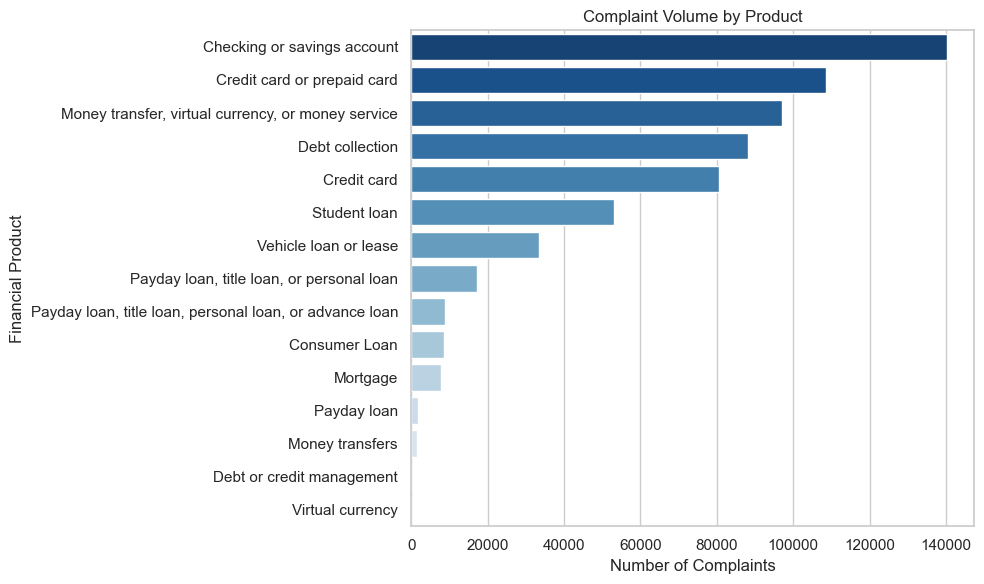

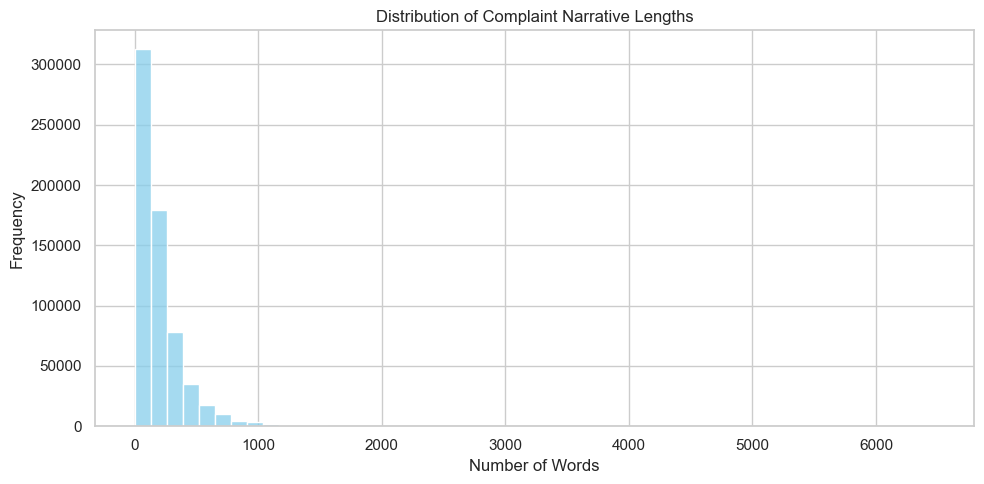

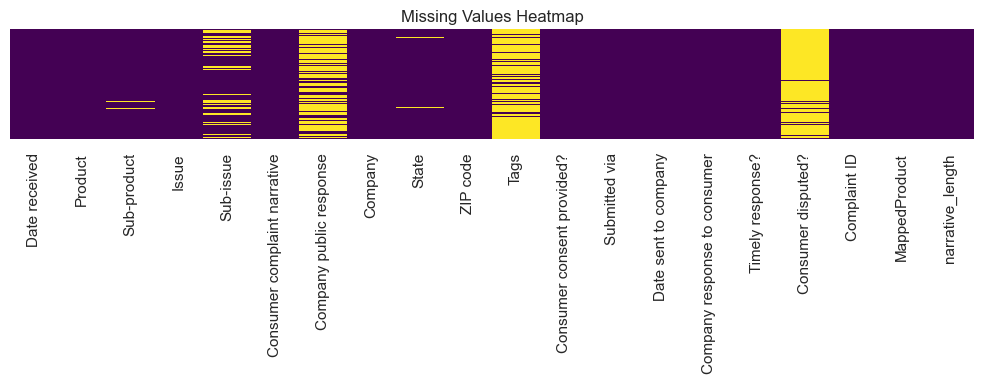

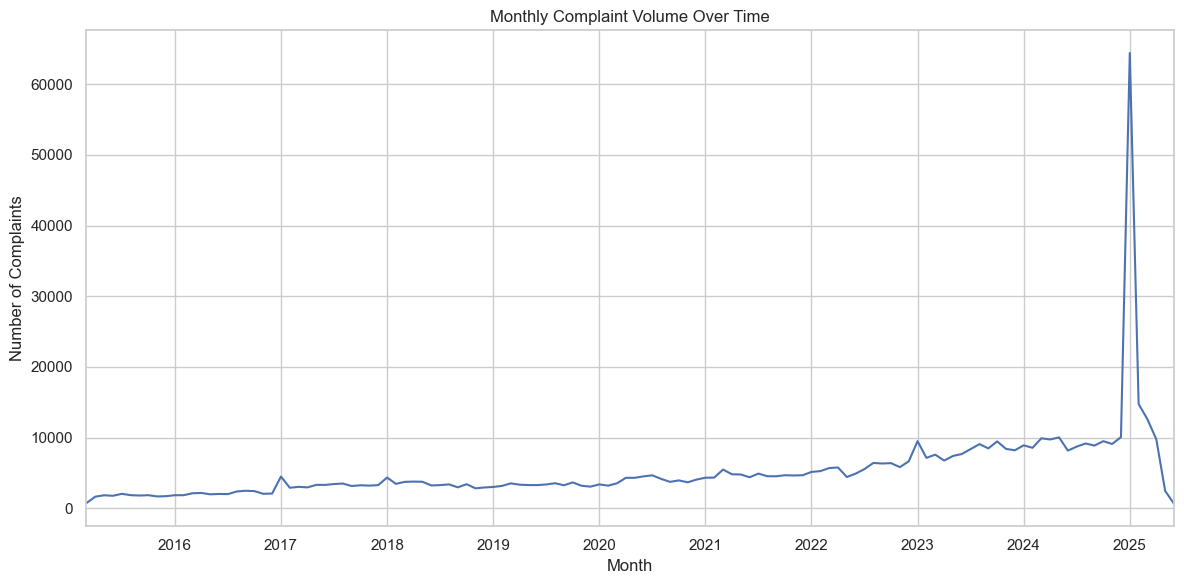

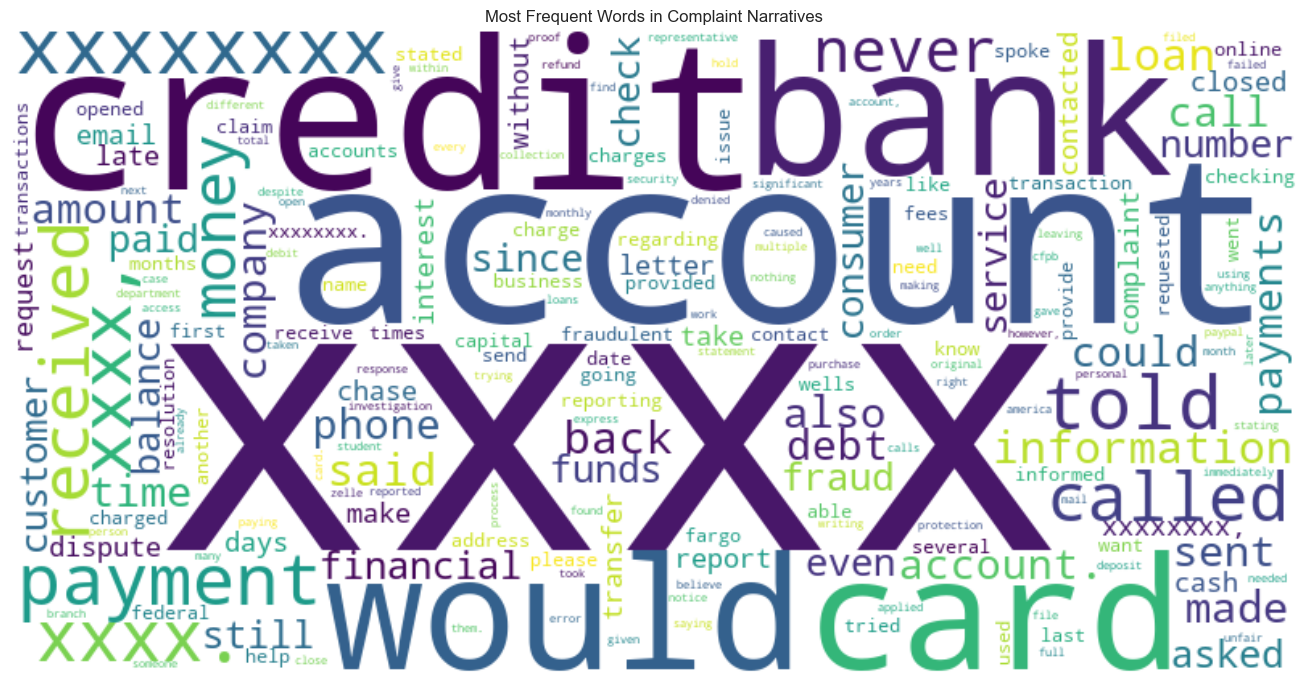

✅ EDA visualizations generated successfully.


In [6]:
# ------------------------------------------------------------------------------
# 📊 Generate Exploratory Visualizations (Modular, Defensive, Styled for B5W6)
# ------------------------------------------------------------------------------

# ✅ Import the dedicated EDA visualizer class (decoupled from loader)
from src.eda.eda_visualizer import ComplaintEDAVisualizer

# ✅ Check if cleaned DataFrame exists, is valid, and non-empty
if "df" in locals() and isinstance(df, pd.DataFrame) and not df.empty:
    try:
        # Initialize the EDA visualizer with the cleaned DataFrame
        eda = ComplaintEDAVisualizer(df)

        # Generate all EDA plots in sequence
        eda.generate_all()

        print("✅ EDA visualizations generated successfully.")

    except Exception as e:
        print(f"❌ EDA generation failed: {e}")

else:
    print("⚠️ Skipping EDA: No valid cleaned complaint dataset found.")